In [24]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import locale
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, 
    Flatten, Dropout, Dense, 
    Input, BatchNormalization, concatenate
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [2]:
dataset_path = "/home/smbh/Projects/house-price-prediction/data/raw/houses-dataset/houses_dataset"

In [3]:
cols = [
    "bedrooms",
    "bathrooms",
    "area",
    "zipcode",
    "price"
]
df = pd.read_csv(dataset_path + "/HousesInfo.txt", sep=" ", header=None, names=cols)
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [4]:
# zipcode to categorical
df["zipcode"] = df["zipcode"].astype("str")

In [5]:
zipcodes, count = np.unique(
    df["zipcode"],
    return_counts=True
)
# dict(zip(zipcodes, count))
df.shape

(535, 5)

In [6]:
# plot histogram of zip codes
fig = px.histogram(
    df,
    x="zipcode",
    nbins=70,
    title="Histogram of Zip Codes"
)
fig.show()

In [7]:
# delete zip codes with less than 25 houses
for (zipcode, count) in zip(zipcodes, count):
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)
df.shape

(362, 5)

In [8]:
# plot histogram of zip codes
fig = px.histogram(
    df,
    x="zipcode",
    nbins=70,
    title="Histogram of Zip Codes"
)
fig.show()

In [9]:
images = []

for i in df.index.values:
    base_path = os.path.sep.join([dataset_path, "{}_*".format(i + 1)])
    house_paths = sorted(list(glob.glob(base_path)))
    input_images = []
    output_images = np.zeros((64, 64, 3), dtype="uint8")
    for house_path in house_paths:
        image = cv2.imread(house_path)
        image = cv2.resize(image, (32, 32))
        input_images.append(image)
    output_images[0:32, 0:32] = input_images[0]
    output_images[0:32, 32:64] = input_images[1]
    output_images[32:64, 32:64] = input_images[2]
    output_images[32:64, 0:32] = input_images[3]
    images.append(output_images)
images = np.array(images)
images.shape

(362, 64, 64, 3)

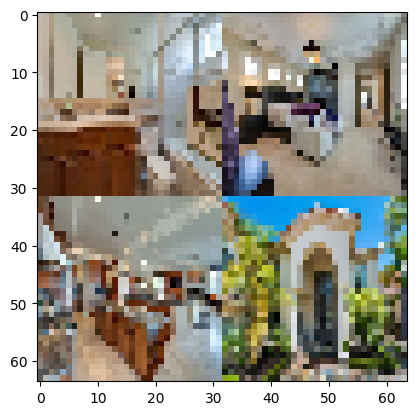

In [10]:
plt.imshow(images[37][..., ::-1])

In [11]:
images = images / 255.0

In [12]:
x_train_attr, x_test_attr, x_train_images, x_test_images = train_test_split(
    df,
    images,
    test_size=0.25,
    random_state=42
)
x_train_attr.shape, x_test_attr.shape, x_train_images.shape, x_test_images.shape

((271, 5), (91, 5), (271, 64, 64, 3), (91, 64, 64, 3))

In [13]:
# Normalization
max_price = df["price"].max()
y_train = x_train_attr["price"] / max_price
y_test = x_test_attr["price"] / max_price
# drop price from x_train_attr and x_test_attr
x_train_attr.drop("price", axis=1, inplace=True)
x_test_attr.drop("price", axis=1, inplace=True)

In [14]:
# Normalization
scaler = MinMaxScaler()
continues_cols = ["bedrooms", "bathrooms", "area"]
x_train_continues = scaler.fit_transform(x_train_attr[continues_cols])
x_test_continues = scaler.transform(x_test_attr[continues_cols])

In [15]:
# one hot encoding of zip codes
lb = LabelBinarizer().fit(df["zipcode"])
x_train_discrete = lb.transform(x_train_attr["zipcode"])
x_test_discrete = lb.transform(x_test_attr["zipcode"])

In [16]:
x_train_attr = np.hstack([x_train_continues, x_train_discrete])
x_test_attr = np.hstack([x_test_continues, x_test_discrete])

print(x_train_attr.shape, x_test_attr.shape)

(271, 10) (91, 10)


In [19]:
mlp = Sequential()
mlp.add(Dense(8, input_shape=(x_train_attr.shape[1],), activation="relu"))
mlp.add(Dense(4, activation="relu"))

2023-01-29 15:00:53.238671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smbh/venvs/house_price_prediction/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-29 15:00:53.238936: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 15:00:53.238952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hope): /proc/driver/nvidia/version does not exist
2023-01-29 15:00:53.239609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Ten

In [20]:
width, height, depth = x_train_images.shape[1:]
width, height, depth

(64, 64, 3)

In [21]:
filters = (16, 32, 64)
input_shape = (width, height, depth)
channel_dim = -1

In [23]:
inputs = Input(shape=input_shape)

for (i, f) in enumerate(filters):
    if i == 0:
        x = inputs
    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channel_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
x = Dense(4)(x)
x = Activation("relu")(x)

cnn = Model(inputs, x)
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 activation_5 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640

In [27]:
combined_input = concatenate([cnn.output, mlp.output])
x = Dense(4, activation="relu")(combined_input)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[cnn.input, mlp.input], outputs=x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 16)   448         ['input_2[0][0]']                
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 16)   0           ['conv2d_3[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 64, 64, 16)  64          ['activation_5[0][0]']           
 rmalization)                                                                               

In [29]:
opt = Adam(learning_rate=1e-3, weight_decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [30]:
history = model.fit(
    [x_train_images, x_train_attr],
    y_train,
    validation_data=([x_test_images, x_test_attr], y_test),
    epochs=200,
    batch_size=8
)

Epoch 1/200
34/34 [==============================] - 2s 12ms/step - loss: 702.1579 - val_loss: 104.2853
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 418.5096 - val_loss: 98.0969
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 247.3139 - val_loss: 83.6381
Epoch 4/200
34/34 [==============================] - 0s 7ms/step - loss: 185.3008 - val_loss: 75.1718
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 134.7509 - val_loss: 69.1561
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 122.1616 - val_loss: 90.0211
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 118.1013 - val_loss: 166.9148
Epoch 8/200
34/34 [==============================] - 0s 7ms/step - loss: 103.7867 - val_loss: 151.4455
Epoch 9/200
34/34 [==============================] - 0s 7ms/step - loss: 90.7455 - val_loss: 353.9519
Epoch 10/200
34/34 [==============================] - 0s 7ms/step - loss: 98.4

In [31]:
# Plot training and validation loss
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=history.history["loss"],
    name="Training Loss"
))
fig.add_trace(go.Scatter(
    y=history.history["val_loss"],
    name="Validation Loss"
))
fig.update_layout(
    title="Training and Validation Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss"
)
fig.show()

In [33]:
preds = model.predict([x_test_images, x_test_attr])

3/3 [==============================] - 0s 8ms/step


In [34]:
diff = preds.flatten() - y_test
percent_diff = (diff / y_test) * 100
abs_percent_diff = np.abs(percent_diff)

mean = np.mean(abs_percent_diff)
std = np.std(abs_percent_diff)

In [35]:
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print(f"avg. house price: {locale.currency(df['price'].mean(), grouping=True)}")
print(f"mean: {mean:.2f}%, std: {std:.2f}%")

avg. house price: $533,388.27
mean: 24.10%, std: 19.43%
